# Grab the vertices of the glacier terminus boxes in pixel coordinates

### Jukes Liu

### Import packages, set basepath, grab BoxIDs for terminus boxes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [2]:
#read in Terminus Box dataframe
pathrows_df = pd.read_csv(basepath+'LS_pathrows.csv', sep=',', usecols =[0,1,2], dtype=str, nrows =10)
pathrows_df = pathrows_df.set_index('BoxID')
pathrows_df.head()

,Path,Row
BoxID,,
001,034,005
002,031,005
004,031,005
033,008,014
120,232,017


### Read in terminus box rasters

In [3]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in pathrows_df.index:
    #load in the raster
    boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes.update( {BoxID: termbox} )

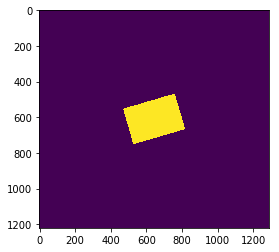

In [4]:
#visualize terminus box rasters by BoxID
termplot = plt.imshow(termboxes['004'])
plt.show()

### Find location of box coordinates of interest

    A) Leftmost x-value: smallest x
    B) Two left vertices & midpoint
        B1) Top Left (lowest x*y)
        B2) Bottom Left (highest y/x)
        B3) Midpoint of B1 and B2:
$\dfrac{x_{1}+x_{2}}{2}$ , $\dfrac{y_{1}+y_{2}}{2}$

In [5]:
#create dictionary to store the coordinates of the box rasters
boxes_xcoords = {}
boxes_ycoords = {}

#create dictionaries for leftmost xvalues (A) and the leftmost vertices of boxes (B1, B2)
leftmost_xvalues = {}
topleft_coords = {}
bottomleft_coords = {}

#create dictionaries to store the midpoints (B3)
midpoints_x = {}
midpoints_y = {}

#for all the box rasters
for BoxID in pathrows_df.index:
    BOI = termboxes[BoxID]
    #find the coordinates of where the pixel value is nonzero
    yindices, xindices = np.where(BOI > 0)
#     print(BoxID, yindices)
#     box_coords = list(zip(xindices, yindices))
    #add box coordinates to the dictionary
    boxes_ycoords.update( {BoxID: yindices})
    boxes_xcoords.update( {BoxID: xindices})
    
    
    #1) Find the leftmost x-coordinate
    leftmost_x = np.min(xindices)
    #Add to dictionary of leftmost x values
    leftmost_xvalues.update( {BoxID: leftmost_x} )
    
 
    #2) Find the two left vertices
    #FIND THE TOP LEFT COORDINATES (lowest x*y)
    xy = xindices*yindices
    #Find the lowest xy value
    min_xy = np.min(xy)
    #Find the x and y pair corresponding to that xy using the index
    min_xy_i = np.where(xy == min_xy)[0][0]
#     print(min_xy, min_xy_i)
    topleft = [xindices[min_xy_i], yindices[min_xy_i]]
#     print("Top left", topleft)
    #Add to dictionary of topleft coordinates
    topleft_coords.update(  {BoxID: topleft}  )

    #FIND THE BOTTOM LEFT COORDINATE(highest y/x)
    y_x = yindices/xindices
    #Find the highest y/x value
    max_y_x = np.max(y_x)
    #Find the x and y pair corresponding to that y/x using the index
    max_y_x_i = np.where(y_x == max_y_x)[0][0]
#     print(max_y_x, max_y_x_i)
    bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
#     print("Bottom left", bottomleft)
    #Add to dictionary of bottomleft coordinates
    bottomleft_coords.update( {BoxID: bottomleft}  )
    
    #CALCULATE THE MIDPOINTS
    midpoint_x = (topleft[0]+bottomleft[0])/2
    midpoint_y = (topleft[1]+bottomleft[1])/2
    midpoint = [midpoint_x, midpoint_y]
    #Add x and y coordinates to dictionaries
    midpoints_x.update( {BoxID: midpoint_x}  )
    midpoints_y.update( {BoxID: midpoint_y}  )

# print("Leftmost x values:", leftmost_xvalues)
# print("Top left coordinates:", topleft_coords)
# print("Bottom left coordinates:", bottomleft_coords)

### Check the left box vertices and midpoints by plotting over terminus box:

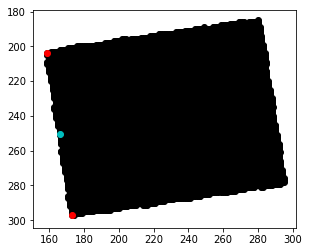

In [9]:
#Choose which glacier BoxID to check:
BOI_ID = '531'

#plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k')
#plot the top and bottom left vertices in red
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='r')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='r')
#plot midpoints in cyan
plt.scatter(midpoints_x[BOI_ID], midpoints_y[BOI_ID], c='c')

plt.gca().invert_yaxis()
plt.axis('scaled')
plt.show()

### Turn the dictionaries storing the coordinates into DataFrames and concatenate together

In [42]:
leftmost_df = pd.DataFrame.from_dict(leftmost_xvalues, orient='index')
leftmost_df.columns = ["leftmost_x"]

midpoints_x_df = pd.DataFrame.from_dict(midpoints_x, orient='index')
midpoints_x_df.columns = ["midpoint_x"]

midpoints_y_df = pd.DataFrame.from_dict(midpoints_y, orient='index')
midpoints_y_df.columns = ["midpoint_y"]

total_df = pd.concat([leftmost_df, midpoints_x_df, midpoints_y_df], axis=1, join_axes=[leftmost_df.index])
total_df.head()

,leftmost_x,midpoint_x,midpoint_y
001,114,117.0,164.5
002,466,468.0,575.5
004,471,500.0,651.0
033,362,362.5,473.0
120,109,111.0,148.5


### Combine with original pathrows DataFrame and export to csv

In [43]:
updated_df = pathrows_df.join(total_df, how='inner')
updated_df

,Path,Row,leftmost_x,midpoint_x,midpoint_y
BoxID,,,,,
001,034,005,114,117.0,164.5
002,031,005,466,468.0,575.5
004,031,005,471,500.0,651.0
033,008,014,362,362.5,473.0
120,232,017,109,111.0,148.5
174,232,017,243,260.5,344.5
235,232,015,171,177.0,201.0
259,232,015,212,215.0,484.0
277,232,015,143,144.5,204.0


In [44]:
updated_df.to_csv(path_or_buf = basepath+'Boxes_coords_pathrows.csv', sep=',')